In [2]:
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Image and batch settings
image_size = 128
batch_size = 32

# Data preparation
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    'ProcessedSpilt_dataset/train',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
val_generator = datagen.flow_from_directory(
    'ProcessedSpilt_dataset/val',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
test_generator = datagen.flow_from_directory(
    'ProcessedSpilt_dataset/test',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_generator.num_classes
print(f"Detected Classes: {num_classes}")
print(f"Class Labels: {train_generator.class_indices}")

# Define CNN builder with parameters
def build_model(learning_rate, dropout_rate, dense_units):
    model = Sequential([
        tf.keras.Input(shape=(image_size, image_size, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# WOA Parameters
num_whales = 3
iterations = 3
search_space = {
    "learning_rate": [0.0005, 0.001, 0.002],
    "dropout": [0.3, 0.4, 0.5],
    "dense_units": [64, 128, 256]
}

# Initialize whale positions
population = []
for _ in range(num_whales):
    whale = {
        "learning_rate": random.choice(search_space["learning_rate"]),
        "dropout": random.choice(search_space["dropout"]),
        "dense_units": random.choice(search_space["dense_units"])
    }
    population.append(whale)

best_whale = None
best_val_acc = 0

# Begin optimization loop
for iter in range(iterations):
    print(f"\n--- WOA Iteration {iter+1}/{iterations} ---")
    for i, whale in enumerate(population):
        print(f" Whale {i+1} Params: {whale}")
        model = build_model(whale["learning_rate"], whale["dropout"], whale["dense_units"])
        model.fit(train_generator, epochs=10, validation_data=val_generator, verbose=0)
        _, val_acc = model.evaluate(val_generator, verbose=0)

        print(f"  → Validation Accuracy: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_whale = whale
            best_model = model

    # Simulated encircling behavior (simplified update)
    for whale in population:
        whale["learning_rate"] = random.choice(search_space["learning_rate"])
        whale["dropout"] = random.choice(search_space["dropout"])
        whale["dense_units"] = random.choice(search_space["dense_units"])

# Final model evaluation
print(f"\n✅ Best WOA Params: {best_whale}")
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"\n🎯 Final Test Accuracy (WOA Optimized): {test_acc:.2%}")


Found 2240 images belonging to 5 classes.
Found 480 images belonging to 5 classes.
Found 480 images belonging to 5 classes.
Detected Classes: 5
Class Labels: {'AlluvialSoil': 0, 'BlackSoil': 1, 'RedSoil': 2, 'SandySoil': 3, 'claySoil': 4}

--- WOA Iteration 1/3 ---
 Whale 1 Params: {'learning_rate': 0.002, 'dropout': 0.5, 'dense_units': 256}
  → Validation Accuracy: 0.9812
 Whale 2 Params: {'learning_rate': 0.001, 'dropout': 0.3, 'dense_units': 256}
  → Validation Accuracy: 0.9854
 Whale 3 Params: {'learning_rate': 0.001, 'dropout': 0.4, 'dense_units': 64}
  → Validation Accuracy: 0.9542

--- WOA Iteration 2/3 ---
 Whale 1 Params: {'learning_rate': 0.0005, 'dropout': 0.3, 'dense_units': 256}
  → Validation Accuracy: 0.9583
 Whale 2 Params: {'learning_rate': 0.002, 'dropout': 0.5, 'dense_units': 256}
  → Validation Accuracy: 0.9854
 Whale 3 Params: {'learning_rate': 0.0005, 'dropout': 0.3, 'dense_units': 128}
  → Validation Accuracy: 0.9958

--- WOA Iteration 3/3 ---
 Whale 1 Params: {'

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Confusion Matrix:
[[96  0  0  0  0]
 [ 0 96  0  0  0]
 [ 0  0 96  0  0]
 [ 2  0  0 94  0]
 [ 0  0  0  0 96]]


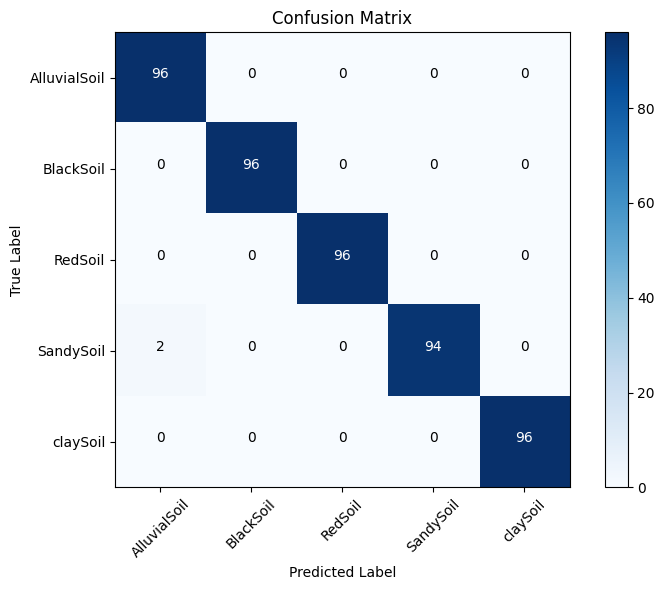


Classification Report:
              precision    recall  f1-score   support

AlluvialSoil       0.98      1.00      0.99        96
   BlackSoil       1.00      1.00      1.00        96
     RedSoil       1.00      1.00      1.00        96
   SandySoil       1.00      0.98      0.99        96
    claySoil       1.00      1.00      1.00        96

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480



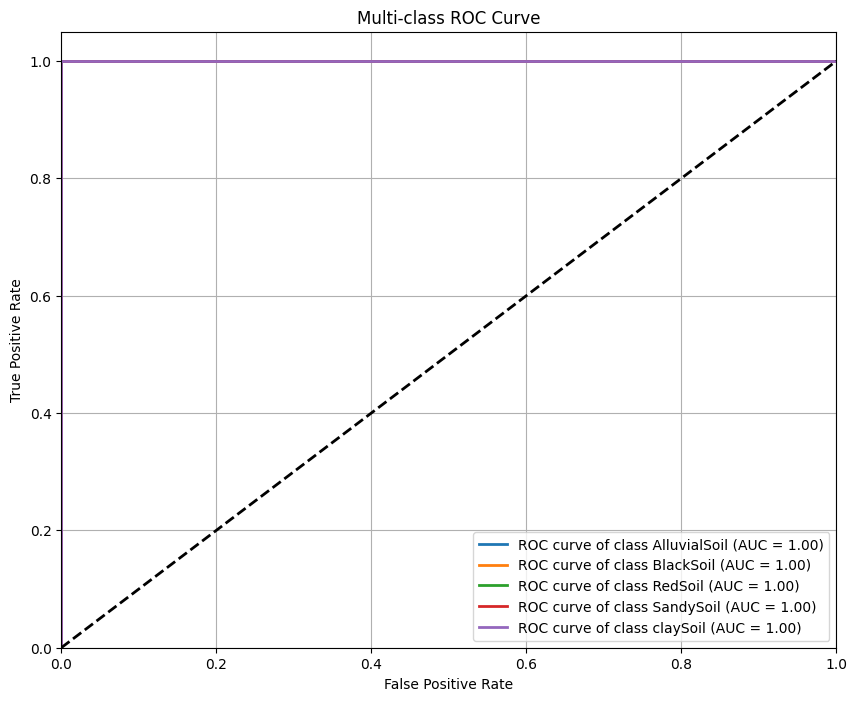

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Make sure test_generator is reset before predictions
test_generator.reset()

# True labels (integers)
y_true = test_generator.classes

# Predicted probabilities from best WOA-optimized model
y_pred_prob = best_model.predict(test_generator, verbose=1)

# Predicted class labels (argmax of predicted probabilities)
y_pred = np.argmax(y_pred_prob, axis=1)

# 1. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

# 2. Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# 3. ROC Curve and AUC for multi-class
# Binarize true labels for ROC curve (one-hot style)
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10,8))
for i, class_label in enumerate(test_generator.class_indices.keys()):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of class {class_label} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()
